In [1]:
import cv2 as cv
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import ipywidgets as widgets

%matplotlib inline

images_root = Path.cwd()/"test-images"

images = {}
for path in images_root.glob("*.jpg"):
    images[path.stem] = cv.imread(str(path))
    print(f"{path} loaded")



/Users/kellenwatt/dev/frc/2024/ring-tracking/test-images/distractions.jpg loaded
/Users/kellenwatt/dev/frc/2024/ring-tracking/test-images/partial.jpg loaded
/Users/kellenwatt/dev/frc/2024/ring-tracking/test-images/centered.jpg loaded
/Users/kellenwatt/dev/frc/2024/ring-tracking/test-images/adjacent.jpg loaded
/Users/kellenwatt/dev/frc/2024/ring-tracking/test-images/far.jpg loaded
/Users/kellenwatt/dev/frc/2024/ring-tracking/test-images/close.jpg loaded


In [2]:
def show_all(images, **kwargs): 
    plt.figure(figsize=[8,5])
    for (i, (path, img)) in enumerate(images.items()):
        ax = plt.subplot(231 + i)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(img, **kwargs)
        plt.title(f"{path} ({img.shape[0]}, {img.shape[1]})")

def image_map(images, f):
    return {path: f(path, img) for (path, img) in images.items()}

def change_format(image, conversion):
    return cv.cvtColor(image, conversion)

def map_format(images, conversion):
    return image_map(images, lambda _p, img: change_format(img, conversion))

In [3]:
# Delays processing sigificantly, so skip unless useful
#show_all(map_format(images, cv.COLOR_BGR2RGB))

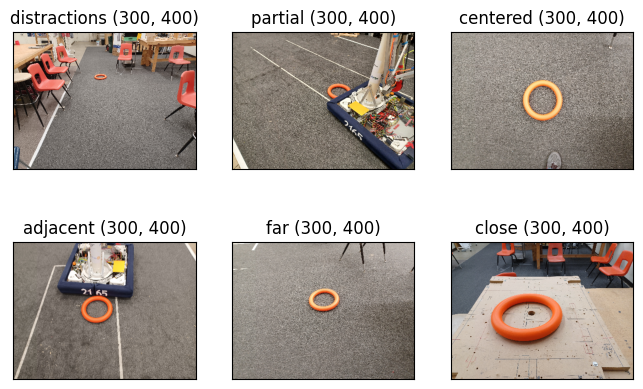

In [4]:
reductions = image_map(images, lambda _p, img: cv.resize(img, None, fx=0.1, fy=0.1))

show_all(map_format(reductions, cv.COLOR_BGR2RGB))

In [5]:
hsl_images = map_format(reductions, cv.COLOR_BGR2HLS_FULL)

In [6]:
def filter_image(img, lower, upper):
    mask = cv.inRange(img, lower, upper)
    return cv.bitwise_and(img, img, mask=mask)

def render_filtered(image_name, hue, sat, light):
    lower = np.array([hue[0], light[0], sat[0]])
    upper = np.array([hue[1], light[1], sat[1]])
    image = filter_image(hsl_images[image_name], lower, upper)
    plt.imshow(change_format(image, cv.COLOR_HLS2RGB))

def show_original(image_name):
    plt.imshow(change_format(hsl_images[image_name], cv.COLOR_HLS2RGB))

In [7]:
image_selector = widgets.Dropdown(description="Image", options=reductions.keys())

hue = widgets.IntRangeSlider(description="Hue", min=0, max=255, value=[0,255])
sat = widgets.IntRangeSlider(description="Saturation", min=0, max=255, value=[0,255])
light = widgets.IntRangeSlider(description="Lightness", min=0, max=255, value=[0,255])
sliders = widgets.VBox([image_selector, hue, light, sat])

filtered = widgets.interactive_output(render_filtered, {
    "image_name": image_selector,
    "hue": hue, #firm [7,32]
    "sat": sat, #[113,216]
    "light": light, #[187,255]
})
original = widgets.interactive_output(show_original, {
    "image_name": image_selector,
})
widgets.VBox([sliders, widgets.HBox([original, filtered])])

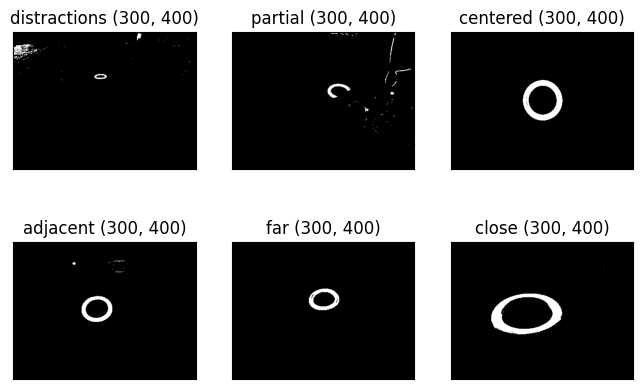

In [8]:
# These values derived by using the tuner above. May require further tuning
lower_limit_hls = np.array([7, 113, 187])
upper_limit_hls = np.array([32, 216, 255])

def binary_filter(img, lower, upper):
    img = filter_image(img, lower, upper)
    img = change_format(change_format(img, cv.COLOR_HLS2BGR), cv.COLOR_BGR2GRAY)
    res, img = cv.threshold(img, 127, 255, cv.THRESH_BINARY)
    return img

filtered = image_map(hsl_images, lambda _p, img: binary_filter(img, lower_limit_hls, upper_limit_hls))
show_all(filtered, cmap="grey")

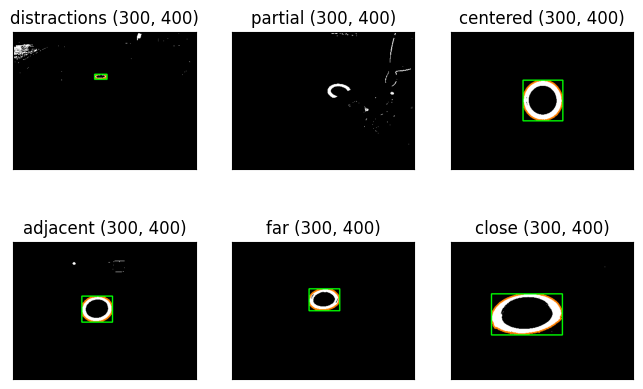

In [9]:
def contour_roundness(con):
    perimeter = cv.arcLength(con, True)
    area = cv.contourArea(con)
    circularity = 4*3.14159265358979323*(area/(perimeter*perimeter))
    return circularity

def apply_contours(img):
    contours, heirarchy = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contours = [c for (i,c) in enumerate(contours) if cv.contourArea(c) > 200 and heirarchy[0][i][3] == -1 and contour_roundness(c) > 0.6]
    img = change_format(img, cv.COLOR_GRAY2RGB)
    img = cv.drawContours(img, contours, -1, (255, 128, 0), 2)
    for c in contours:
        x,y,w,h = cv.boundingRect(c)
        img = cv.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)
    return img


contours = image_map(filtered, lambda _p, img: apply_contours(img))
show_all(contours)

In [10]:
from dataclasses import dataclass
@dataclass
class Point:
    x: int
    y: int

    def normalize(self, origin) -> "Point":
        return Point(origin.x - self.x, origin.y - self.y)

class BoundingBox:
    x: int
    y: int
    width: int
    height: int

    def __init__(self, x, y, w, h):
        self.x = x
        self.y = y
        self.width = w
        self.height = h

    @property
    def top(self) -> int:
        return self.y
    @property
    def left(self) -> int:
        return self.x
    @property
    def bottom(self) -> int:
        return self.y + self.height
    @property
    def right(self) -> int:
        return self.x + self.width
        
    def top_left(self) -> Point:
        return Point(self.left, self.top)
        
    def top_right(self) -> Point:
        return Point(self.right, self.top)
        
    def bottom_left(self) -> Point:
        return Point(self.left, self.bottom)
        
    def bottom_right(self) -> Point:
        return Point(self.right, self.bottom)

    def center(self) -> Point:
        x = (self.left + self.right) // 2
        y = (self.top + self.bottom) // 2
        return Point(x, y)

    def major_axis(self) -> int:
        return max(self.width, self.height)

    def minor_axis(self) -> int:
        return min(self.width, self.height)

class Match:
    full: bool
    box: BoundingBox

    def __init__(self, x, y, w, h, contour, full):
        self.full = full
        self.box = BoundingBox(x, y, w, h)
        self.contour = contour

    def is_full(self) -> bool:
        return self.full

    def is_partial(self) -> bool:
        return not self.full

    def with_context(self, context) -> "ContextualMatch":
        return ContextualMatch(self.box.x, self.box.y, 
                               self.box.width, self.box.height, 
                               self.contour, 
                               self.full, 
                               context)


def detect_ring(img, context=None):
    contours, heirarchy = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    if heirarchy is None:
        return []
    matches = []
    for (c, h) in zip(contours, heirarchy[0]):
        if cv.contourArea(c) < 200 or h[3] != -1:
            continue

        # pretty round and has a child that has no children
        # The last bit is probably overkill and definitely will result in false negatives, 
        # but it's cheap and guarantees a hollow shape
        complete_match = contour_roundness(c) > 0.6 \
            and h[2] != -1 \
            and heirarchy[0][h[2]][2] == -1
        
        match = Match(*cv.boundingRect(c), c, complete_match)
        if context is not None:
            match = match.with_context(context)
        matches.append(match)

    return matches

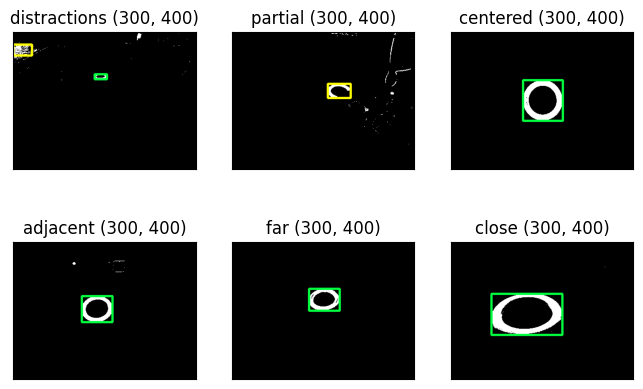

In [11]:
def show_detections(_path, img):
    matches = detect_ring(img)
    img = change_format(img, cv.COLOR_GRAY2RGB)
    for m in matches:
        if m.full:
            color = (0, 255, 63)
        else:
            color= (255, 255, 0)
        b = m.box
        img = cv.rectangle(img, (b.left, b.top), (b.right, b.bottom), color, 3)
    return img

annotated = image_map(filtered, show_detections)
show_all(annotated)

In [12]:
def image_origin(img) -> Point:
    shape = img.shape
    x = shape[1]
    y = shape[0]
    return Point(x//2, y//2)

from typing import Optional
class CameraContext:
    image_dimensions: tuple[int, int]
    # Camera FOV in degrees
    fov: Optional[float]
    # Object width in pixels at 1 meter
    object_width: Optional[int]

    def __init__(self, width, height, fov = None, object_width = None):
        self.image_dimensions = (width, height)
        self.fov = fov
        self.object_width = object_width

    def center(self) -> Point:
        return Point(self.image_dimensions[0]//2, self.image_dimensions[1]//2)

    @property
    def width(self) -> int:
        return self.image_dimensions[0]

    @property
    def height(self) -> int:
        return self.image_dimensions[1]

class ContextualMatch(Match):
    context: CameraContext
    
    def __init__(self, x, y, w, h, contour, full, context):
        super().__init__(x, y, w, h, contour, full)
        self.context = context

    def relative_box(self) -> BoundingBox:
        origin = self.context.center()
        return BoundingBox(self.box.x - origin.x, self.box.y - origin.y, self.box.width, self.box.height)

    def normal_position(self) -> tuple[float, float]:
        width = self.context.width
        height = self.context.height
        pos = self.box.center()
        x_norm = pos.x / width
        y_norm = pos.y / height
        x_norm = x_norm * 2 - 1
        y_norm = y_norm * 2 - 1
        return (x_norm, -y_norm)
    
    def yaw(self) -> Optional[float]:
        if self.context.fov is None or self.is_partial():
            return None
        return self.normal_position()[0] * self.context.fov

    def pitch(self) -> Optional[float]:
        if self.context.fov is None or self.is_partial():
            return None
        return self.normal_position()[1] * self.context.fov

    def distance(self) -> Optional[float]:
        if self.context.object_width is None or self.is_partial():
            return None

        # This may not be a linear thing. Should work beyond a meter, but up close might get dubious
        ratio = self.context.object_width / self.box.major_axis()
        return ratio
    

In [13]:
def calibrate_ring_size() -> int:
    img = filtered["centered"]
    matches = detect_ring(img)
    assert(len(matches) == 1)
    ring = matches[0]
    return max(ring.box.width, ring.box.height)

context = CameraContext(400, 300, object_width=calibrate_ring_size())

finds = image_map(filtered, lambda _p, img: detect_ring(img, context))

distractions
  position: (-0.04500000000000004, 0.3533333333333334)
  Is Full?: True
  distance: 3.2962962962962963
  position: (-0.9, 0.74)
  Is Full?: False
  distance: None
partial
  position: (0.16999999999999993, 0.1466666666666666)
  Is Full?: False
  distance: None
centered
  position: (0.0, 0.00666666666666671)
  Is Full?: True
  distance: 1.0
adjacent
  position: (-0.08499999999999996, 0.026666666666666616)
  Is Full?: True
  distance: 1.328358208955224
far
  position: (0.004999999999999893, 0.16000000000000003)
  Is Full?: True
  distance: 1.328358208955224
close
  position: (-0.17500000000000004, -0.05333333333333323)
  Is Full?: True
  distance: 0.5741935483870968


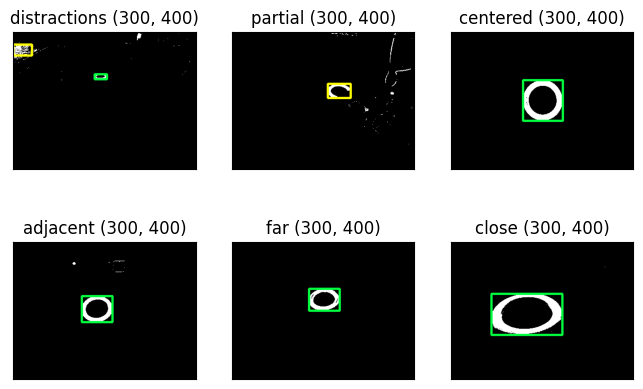

In [14]:
show_all(annotated)
for (name, matches) in finds.items():
    print(f"{name}")
    for m in matches:
        print(f"  position: {m.normal_position()}")
        print(f"  Is Full?: {m.is_full()}")
        print(f"  distance: {m.distance()}")
        

True
Video rendered!


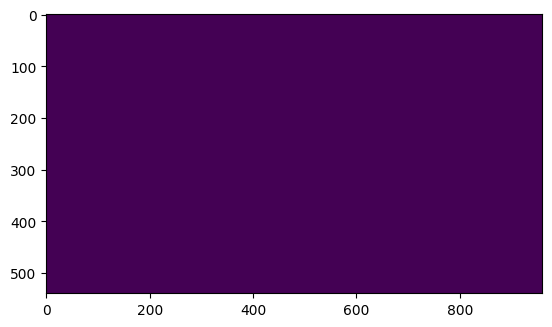

In [31]:
video_path = images_root/"ring-video.mp4"
video = cv.VideoCapture(video_path.as_posix())
print(video.isOpened())
#out_video = cv.VideoWriter("ring-video-annotated.mp4", 
#                           cv.VideoWriter_fourcc(*"XVID"), 20, 
#                           (int(video.get(cv.CAP_PROP_FRAME_WIDTH)/2), int(video.get(cv.CAP_PROP_FRAME_HEIGHT)/2)))
i = 0
while i < 1: #video.isOpened():
    ok, frame = video.read()
    if not ok:
        break
    i += 1
    frame = cv.resize(frame, None, fx=0.5, fy=0.5)
    cv.imwrite((images_root/"video-frames"/f"{i}.jpg").as_posix(), frame)
    hls = change_format(frame, cv.COLOR_BGR2HLS_FULL)
    filtered = binary_filter(hls, upper_limit_hls, lower_limit_hls)
    plt.imshow(filtered)
    matches = detect_ring(filtered)
    img = change_format(hls, cv.COLOR_HLS2BGR_FULL)
    for m in matches:
        if m.full:
            color = (0, 255, 63)
        else:
            color = (255, 255, 0)
        b = m.box
        img = cv.rectangle(img, (b.left, b.top), (b.right, b.bottom), color, 3)
    
    out_video.write(img)
    #plt.imshow(img[:,:,::-1])

video.release()
#out_video.release()
print("Video rendered!")
    

In [23]:
video.release()
out_video.release()
!ffmpeg -y -i ring-video-annotated.mp4 -c:v libx264 "ring-video-annotatedx264.mp4"  -hide_banner -loglevel error
print("video converted to web format!")

video converted to web format!


In [24]:
from IPython.display import Video
Video(filename="ring-video-annotatedx264.mp4")